In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from hipe4ml.model_handler import ModelHandler
# from hipe4ml.tree_handler import TreeHandler
# from hipe4ml.analysis_utils import train_test_generator
# from hipe4ml import plot_utils, analysis_utils
import ROOT
import gc

In [93]:
def clean_name(name):
    name = name.replace("MC", "")
    name = name.replace(" ", "")
    name = name.replace("(GeV/c)", "")
    name = name.replace("#", "")
    return name
# def hist_to_df(hist, clean_names=False): # For pyROOT histograms
#     """
#     Convert a TH1 or TH2 histogram to a pandas DataFrame.
#     """
#     if hist.ClassName().startswith("TH1"):
#         nbins = hist.GetNbinsX()
#         edges = np.array([hist.GetBinLowEdge(i) for i in range(1, nbins+2)])
#         values = np.array([hist.GetBinContent(i) for i in range(1, nbins+1)])

#         x_name = hist.GetXaxis().GetTitle()
#         if clean_names:
#             x_name = clean_name(x_name)

#         return pd.DataFrame({
#             f"{x_name}_left": edges[:-1],
#             f"{x_name}_right": edges[1:],
#             "counts": values
#         })
    
#     elif hist.ClassName().startswith("TH2"):
#         nx = hist.GetNbinsX()
#         ny = hist.GetNbinsY()
#         x_edges = np.array([hist.GetXaxis().GetBinLowEdge(i) for i in range(1, nx+2)])
#         y_edges = np.array([hist.GetYaxis().GetBinLowEdge(i) for i in range(1, ny+2)])

#         data = []
#         for i in range(1, nx+1):
#             for j in range(1, ny+1):
#                 x_left, x_right = x_edges[i-1], x_edges[i]
#                 y_left, y_right = y_edges[j-1], y_edges[j]
#                 count = hist.GetBinContent(i, j)
#                 data.append([x_left, x_right, y_left, y_right, count])
#         xAxisName = hist.GetXaxis().GetTitle()
#         yAxisName = hist.GetYaxis().GetTitle()
#         columnsNames = [f"{xAxisName}_left", f"{xAxisName}_right", f"{yAxisName}_left", f"{yAxisName}_right", "counts"]
#         return pd.DataFrame(data, columns=columnsNames)
    
#     else:
#         raise NotImplementedError(f"Only TH1 and TH2 supported, but got {hist.ClassName()}")



def hist_to_df(hist, clean_names=True):  # For pyROOT histograms
    """
    Convert a TH1 or TH2 histogram to a pandas DataFrame.
    If clean_names=True, removes spaces and 'MC' from axis names.
    """



    if hist.ClassName().startswith("TH1"):
        nbins = hist.GetNbinsX()
        edges = np.array([hist.GetBinLowEdge(i) for i in range(1, nbins+2)])
        values = np.array([hist.GetBinContent(i) for i in range(1, nbins+1)])

        x_name = hist.GetXaxis().GetTitle()
        if clean_names:
            x_name = clean_name(x_name)

        return pd.DataFrame({
            f"{x_name}_left": edges[:-1],
            f"{x_name}_right": edges[1:],
            "counts": values
        })

    elif hist.ClassName().startswith("TH2"):
        nx = hist.GetNbinsX()
        ny = hist.GetNbinsY()
        x_edges = np.array([hist.GetXaxis().GetBinLowEdge(i) for i in range(1, nx+2)])
        y_edges = np.array([hist.GetYaxis().GetBinLowEdge(i) for i in range(1, ny+2)])

        data = []
        for i in range(1, nx+1):
            for j in range(1, ny+1):
                x_left, x_right = x_edges[i-1], x_edges[i]
                y_left, y_right = y_edges[j-1], y_edges[j]
                count = hist.GetBinContent(i, j)
                data.append([x_left, x_right, y_left, y_right, count])

        x_name = hist.GetXaxis().GetTitle()
        y_name = hist.GetYaxis().GetTitle()
        if clean_names:
            x_name = clean_name(x_name)
            y_name = clean_name(y_name)

        columnsNames = [f"{x_name}_left", f"{x_name}_right", f"{y_name}_left", f"{y_name}_right", "counts"]
        return pd.DataFrame(data, columns=columnsNames)

    else:
        raise NotImplementedError(f"Only TH1 and TH2 supported, but got {hist.ClassName()}")








def rebin_df(df, new_edges, x_left="x_left", x_right="x_right", counts="counts"):
    new_counts = []
    
    for i in range(len(new_edges)-1):
        bin_left = new_edges[i]
        bin_right = new_edges[i+1]
        # Select all original bins that overlap the new bin
        mask = (df[x_right] > bin_left) & (df[x_left] < bin_right)
        
        # Sum the counts of overlapping bins (simple sum; more precise weighting can be applied if needed)
        new_counts.append(df.loc[mask, counts].sum())
        
    return pd.DataFrame({
        "bin_left": new_edges[:-1],
        "bin_right": new_edges[1:],
        "counts": new_counts
    })

def df_to_root_graph(df, graph_name="graph", graph_title="Histogram with errors", yerr=None):
    """
    Convert a pandas DataFrame with 'bin_left', 'bin_right', 'counts' to a ROOT TGraphErrors
    with horizontal error bars corresponding to bin widths.
    """
    bin_left = df["bin_left"].values
    bin_right = df["bin_right"].values
    counts = df["counts"].values

    x = (bin_left + bin_right) / 2.0           # bin centers
    y = counts
    ex = (bin_right - bin_left) / 2.0          # horizontal errors = half bin width
    # ey = np.sqrt(counts)                        # vertical errors (Poisson), can set to 0 if not needed
    ey=np.zeros_like(y)  # No vertical errors, can be set to zero
    if yerr is not None:
        ey = yerr              # vertical errors from DataFrame if provided
    graph = ROOT.TGraphErrors(len(x),
                              x.astype(float), y.astype(float),
                              ex.astype(float), ey.astype(float))
    graph.SetName(graph_name)
    graph.SetTitle(graph_title)
    graph.SetMarkerStyle(20)
    # graph.SetMarkerSize(0.8)

    return graph

# def EfficiencyPlot(a, b, path, graph_title, legText, ptBins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 12]):
#     root_file = ROOT.TFile.Open(path)    
#     output_dir_name = 'analysis-same-event-pairing/output;1'
#     output_dir = root_file.Get(output_dir_name)
#     if not output_dir:
#         print(f"{output_dir_name} not found in the ROOT file.")
#         return None, None
#     for JPsiList in output_dir:
#         # print("JPsiList: ", JPsiList.GetName())
#         if JPsiList.GetName() == a:
#             aList = JPsiList
#         elif JPsiList.GetName() == b:
#             bList = JPsiList
#     if not aList:
#         print(f"{a} not found in the output directory!")
#         return None, None
#     if not bList:
#         print(f"{b} not found in the output directory!")
#         return None, None

#     aptDf = None
#     bptDf = None
#     for hist in aList:
#         if "Truth" in a:
#             if hist.GetName() == "PtMC":
#                 aptDf = hist_to_df(hist)
#         else:
#             if hist.GetName() == "Mass_Pt":
#                 aptDf = hist_to_df(hist)
#     for hist in bList:
#         if "Truth" in b:
#             if hist.GetName() == "PtMC":
#                 bptDf = hist_to_df(hist)
#         else:
#             if hist.GetName() == "Mass_Pt":
#                 bptDf = hist_to_df(hist)
#     aptDfReb = rebin_df(aptDf, ptBins, x_left="mass_left", x_right="mass_right", counts="counts")
#     bptDfReb = rebin_df(bptDf, ptBins, x_left="mass_left", x_right="mass_right", counts="counts")
#     df_eff = aptDfReb.copy()
#     df_eff['counts'] = df_eff['counts'] / bptDfReb['counts']

#     # Statistical Uncertainty
#     eff_statUnc = np.sqrt(df_eff['counts'] * (1 - df_eff['counts']) / bptDfReb['counts']) # Binomial uncertainty
#     graph = df_to_root_graph(df_eff, "efficiency_graph", graph_title, yerr=np.array(eff_statUnc))
#     ROOT.SetOwnership(graph, True)
#     graph.GetXaxis().SetTitle("p_{T} (GeV/c)")
#     graph.GetYaxis().SetTitle("A x #epsilon")
#     graph.SetMarkerColor(ROOT.kRed-2)
#     graph.SetLineColor(ROOT.kRed-2)
#     graph.SetLineWidth(2)

#     legend = ROOT.TLegend(0.55, 0.7, 0.9, 0.9)
#     legend.AddEntry(legend,"pp #sqrt s = 13.6 TeV", "")
#     legend.AddEntry(graph, legText, "p")
#     legend.SetFillStyle(0)
#     legend.SetBorderSize(0)
#     legend.SetTextSize(0.04)

#     output_dir.Delete()
#     root_file.Close()
#     root_file.Delete()

#     return graph, legend


def EfficiencyPlot(a, b, path, graph_title, legText, ptBins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 12]):
    root_file = ROOT.TFile.Open(path)    
    output_dir_name = 'analysis-same-event-pairing/output;1'
    output_dir = root_file.Get(output_dir_name)
    if not output_dir:
        print(f"{output_dir_name} not found in the ROOT file.")

    aList = None
    bList = None
    for JPsiList in output_dir:
        # print("JPsiList: ", JPsiList.GetName())
        if JPsiList.GetName() == a:
            aList = JPsiList
        elif JPsiList.GetName() == b:
            bList = JPsiList
    if not aList:
        print(f"{a} not found in the output directory!")
    if not bList:
        print(f"{b} not found in the output directory!")

    df_a = None
    df_b = None

    for hist in aList:
        if "Truth" in a:
            if hist.GetName() == "EtaMC_PtMC":
                df_a = hist_to_df(hist, clean_names=True)
        else:
            if hist.GetName() == "Eta_Pt":
                df_a = hist_to_df(hist, clean_names=True)
    for hist in bList:
        if "Truth" in b:
            if hist.GetName() == "EtaMC_PtMC":
                df_b = hist_to_df(hist, clean_names=True)
        else:
            if hist.GetName() == "Eta_Pt":
                df_b = hist_to_df(hist, clean_names=True)
    
    # filter out |eta| > 0.9
    df_aFilt = df_a[~((df_a["eta_left"] < -0.9001) | (df_a["eta_right"] > 0.9001))] # 0.9001 due to floating-point error
    df_bFilt = df_b[~((df_b["eta_left"] < -0.9001) | (df_b["eta_right"] > 0.9001))]

    df_aFiltReb = rebin_df(df_aFilt, ptBins, x_left="p_{T}_left", x_right="p_{T}_right", counts="counts")
    df_bFiltReb = rebin_df(df_bFilt, ptBins, x_left="p_{T}_left", x_right="p_{T}_right", counts="counts")

    df_eff = df_aFiltReb.copy()
    df_eff['counts'] = df_eff['counts'] / df_bFiltReb['counts']

    # Statistical Uncertainty
    eff_statUnc = np.sqrt(df_eff['counts'] * (1 - df_eff['counts']) / df_bFiltReb['counts']) # Binomial uncertainty
    graph = df_to_root_graph(df_eff, "efficiency_graph", graph_title, yerr=np.array(eff_statUnc))
    ROOT.SetOwnership(graph, True)
    graph.GetXaxis().SetTitle("p_{T} (GeV/c)")
    graph.GetYaxis().SetTitle("A x #epsilon")
    graph.SetMarkerColor(ROOT.kRed-2)
    graph.SetLineColor(ROOT.kRed-2)
    graph.SetLineWidth(2)

    legend = ROOT.TLegend(0.55, 0.7, 0.9, 0.9)
    legend.AddEntry(legend,"pp #sqrt s = 13.6 TeV", "")
    legend.AddEntry(graph, legText, "p")
    legend.SetFillStyle(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.04)

    output_dir.Delete()
    root_file.Close()
    root_file.Delete()

    return graph, legend

In [3]:
dir_path = '~/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency'
filename = 'LHC25b16_MCSignals25-08-25.root'
path = f"{dir_path}/{filename}"

In [4]:
# Prompt
graph25b16prompt, legendPrompt = EfficiencyPlot(
        a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromPromptJPsi",
    b="MCTruthGenSel_promptJpsi",
    path=path,
    graph_title="Prompt J/#psi Reconstruction Efficiency",
    legText="LHC25b16, prompt"
)

KeyError: 'mass_right'

Error in <TBufferFile::CheckByteCount>: object of class TList read too many bytes: 1417808973 instead of 344067149
Warning in <TBufferFile::CheckByteCount>: TList::Streamer() not in sync with data on file /home/ferrandi/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency/LHC25b16_MCSignals25-08-25.root, fix Streamer()


In [ ]:
cPrompt = ROOT.TCanvas()
graph25b16prompt.SetTitle("Prompt J/#psi Reconstruction Efficiency (over 'sel')") #Change previous title
graph25b16prompt.Draw("AP")
legendPrompt.Draw()
cPrompt.Draw()

In [ ]:
# Non prompt
graph25b16nonprompt, legendNonPrompt = EfficiencyPlot(
    a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromNonPromptJPsi",
    b="MCTruthGenSel_nonPromptJpsi",
    path=path,
    graph_title="Non Prompt J/#psi Reconstruction Efficiency",
    legText="LHC25b16, non-prompt"
)

In [ ]:
cNonPrompt = ROOT.TCanvas()
graph25b16nonprompt.SetTitle("Non Prompt J/#psi Reconstruction Efficiency (over 'sel')")
graph25b16nonprompt.Draw("AP")
legendNonPrompt.Draw()
cNonPrompt.Draw()

In [ ]:
graphs = [graph25b16prompt, graph25b16nonprompt]
legends = [legendPrompt, legendNonPrompt]

n = len(graphs)
cAll = ROOT.TCanvas("c", "Side by Side", 500*n , 400)

# for i, (g, leg) in enumerate(zip(graphs, legends)):
#     cAll.cd()  # volta para o canvas principal para criar o próximo pad
#     pad = ROOT.TPad(f"pad{i}", f"pad{i}", i/n, 0, (i+1)/n, 1)
#     pad.Draw()
#     pad.cd()
    
#     g.Draw("AP")   # ou "APL" dependendo do tipo
#     leg.Draw()

cAll.Divide(n, 1)
for i, (g, leg) in enumerate(zip(graphs, legends), start=1):
    cAll.cd(i)
    g.Draw("AP")
    leg.Draw()


# cAll.Update()
cAll.Draw()


In [ ]:
b16c = ROOT.TCanvas("b16c", "b16c", 800, 600)
graph25b16prompt.SetLineColor(ROOT.kBlue-2)
graph25b16prompt.SetMarkerColor(ROOT.kBlue-2)
graph25b16nonprompt.SetTitle("J/#psi Reconstruction Efficiency (over 'sel')")
graph25b16nonprompt.Draw("AP") # graph with greater axis must be drawn first
graph25b16prompt.Draw("P SAME")
legb16 = legendPrompt.Clone("legb16")
# legendPrompt.Draw()
legb16.AddEntry(graph25b16nonprompt, "LHC25b16, non-prompt", "p")
legb16.Draw()
b16c.Draw()

In [ ]:
graph25b16nonprompt, legendNonPrompt = EfficiencyPlot(
    a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromNonPromptJPsi",
    b="MCTruthGenSel_nonPromptJpsi",
    path=path,
    graph_title="Non Prompt J/#psi Reconstruction Efficiency",
    legText="LHC25b16, non-prompt"
)

In [ ]:
# a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromPromptJPsi"
# b="MCTruthGenSel_promptJpsi"
# graph_title="Prompt J/#psi Reconstruction Efficiency"
# legText="LHC25b16, non-prompt"
# root_file = ROOT.TFile.Open(path)    
# output_dir_name = 'analysis-same-event-pairing/output;1'
# output_dir = root_file.Get(output_dir_name)

# aList = None
# bList = None
# if not output_dir:
#     print(f"{output_dir_name} not found in the ROOT file.")
# for JPsiList in output_dir:
#     # print("JPsiList: ", JPsiList.GetName())
#     if JPsiList.GetName() == a:
#         aList = JPsiList
#     elif JPsiList.GetName() == b:
#         bList = JPsiList
# if not aList:
#     print(f"{a} not found in the output directory!")
# if not bList:
#     print(f"{b} not found in the output directory!")

# df_a = None
# df_b = None


Error in <TBufferFile::CheckByteCount>: object of class TList read too many bytes: 1417808973 instead of 344067149
Warning in <TBufferFile::CheckByteCount>: TList::Streamer() not in sync with data on file /home/ferrandi/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency/LHC25b16_MCSignals25-08-25.root, fix Streamer()


In [ ]:
# for hist in aList:
#     if "Truth" in a:
#         if hist.GetName() == "EtaMC_PtMC":
#             df_a = hist_to_df(hist, clean_names=True)
#             df_aFilt = df_a[~((df_a["eta_left"] < -0.9001) | (df_a["eta_right"] > 0.9001))] # 0.9001 due to floating-point error
#     else:
#         if hist.GetName() == "Eta_Pt":
#             df_a = hist_to_df(hist, clean_names=True)
#             df_aFilt = df_a[~((df_a["eta_left"] < -0.9001) | (df_a["eta_right"] > 0.9001))]
# for hist in bList:
#     if "Truth" in b:
#         if hist.GetName() == "EtaMC_PtMC":
#             df_b = hist_to_df(hist, clean_names=True)
#             df_bFilt = df_b[~((df_b["eta_left"] < -0.9001) | (df_b["eta_right"] > 0.9001))]
#     else:
#         if hist.GetName() == "Eta_Pt":
#             df_b = hist_to_df(hist, clean_names=True)
#             df_bFilt = df_b[~((df_b["eta_left"] < -0.9001) | (df_b["eta_right"] > 0.9001))]
# print(df_aFilt)
# # print(df_b)
# print(df_bFilt)

      eta_left  eta_right  p_{T}_left  p_{T}_right  counts
440       -0.9       -0.8         0.0          0.5     0.0
441       -0.9       -0.8         0.5          1.0     3.0
442       -0.9       -0.8         1.0          1.5     3.0
443       -0.9       -0.8         1.5          2.0     2.0
444       -0.9       -0.8         2.0          2.5     9.0
...        ...        ...         ...          ...     ...
1155       0.8        0.9        17.5         18.0     0.0
1156       0.8        0.9        18.0         18.5     0.0
1157       0.8        0.9        18.5         19.0     0.0
1158       0.8        0.9        19.0         19.5     0.0
1159       0.8        0.9        19.5         20.0     0.0

[720 rows x 5 columns]
      eta_left  eta_right  p_{T}_left  p_{T}_right  counts
2200      -0.9       -0.8         0.0          0.1     0.0
2201      -0.9       -0.8         0.1          0.2     0.0
2202      -0.9       -0.8         0.2          0.3     1.0
2203      -0.9       -0.8       

    bin_left  bin_right  counts
0        0.0        0.5     5.0
1        0.5        1.0    34.0
2        1.0        1.5    52.0
3        1.5        2.0    59.0
4        2.0        2.5    98.0
5        2.5        3.0    88.0
6        3.0        3.5    87.0
7        3.5        4.0    85.0
8        4.0        4.5    90.0
9        4.5        5.0    67.0
10       5.0        5.5    37.0
11       5.5        6.0    37.0
12       6.0        6.5    22.0
13       6.5        7.0    14.0
14       7.0        7.5     8.0
15       7.5        8.0    13.0
16       8.0        8.5     4.0
17       8.5        9.0     5.0
18       9.0       12.0     7.0
    bin_left  bin_right  counts
0        0.0        0.5    39.0
1        0.5        1.0   296.0
2        1.0        1.5   556.0
3        1.5        2.0   775.0
4        2.0        2.5   911.0
5        2.5        3.0   875.0
6        3.0        3.5   828.0
7        3.5        4.0   745.0
8        4.0        4.5   604.0
9        4.5        5.0   494.0
10      

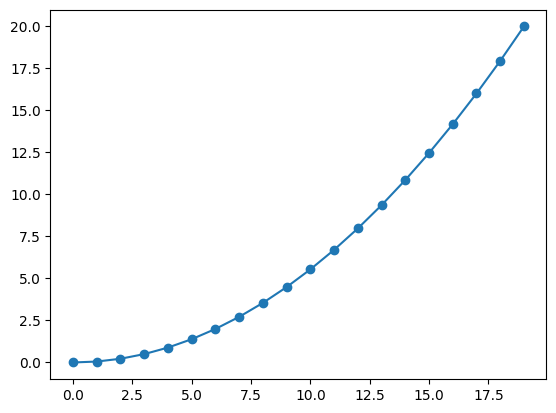

In [ ]:
# ptBins = np.linspace(0, 9, 19)
# ptBins = np.append(ptBins,12)
# # nbins = 20
# # binMax = 12
# # power = 0.8
# # ptBins = np.linspace(0, binMax**power, nbins+1)**(1/power)
# # ptBins = np.exp(np.linspace(0, np.log(binMax+1), N)) - 1
# plt.plot(bins, marker='o')  
# df_aFiltReb = rebin_df(df_aFilt, ptBins, x_left="p_{T}_left", x_right="p_{T}_right", counts="counts")
# df_bFiltReb = rebin_df(df_bFilt, ptBins, x_left="p_{T}_left", x_right="p_{T}_right", counts="counts")
# print(df_aFiltReb)
# print(df_bFiltReb)

In [ ]:
# df_eff = df_aFiltReb.copy()
# df_eff['counts'] = df_eff['counts'] / df_bFiltReb['counts']

# # Statistical Uncertainty
# eff_statUnc = np.sqrt(df_eff['counts'] * (1 - df_eff['counts']) / df_bFiltReb['counts']) # Binomial uncertainty
# graph = df_to_root_graph(df_eff, "efficiency_graph", graph_title, yerr=np.array(eff_statUnc))
# ROOT.SetOwnership(graph, True)
# graph.GetXaxis().SetTitle("p_{T} (GeV/c)")
# graph.GetYaxis().SetTitle("A x #epsilon")
# graph.SetMarkerColor(ROOT.kRed-2)
# graph.SetLineColor(ROOT.kRed-2)
# graph.SetLineWidth(2)

# legend = ROOT.TLegend(0.55, 0.7, 0.9, 0.9)
# legend.AddEntry(legend,"pp #sqrt s = 13.6 TeV", "")
# legend.AddEntry(graph, legText, "p")
# legend.SetFillStyle(0)
# legend.SetBorderSize(0)
# legend.SetTextSize(0.04)

# output_dir.Delete()
# root_file.Close()
# root_file.Delete()


In [94]:
graph25b16promptEta, legendPromptEta = EfficiencyPlot(
    a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromNonPromptJPsi",
    b="MCTruthGenSel_nonPromptJpsi",
    path=path,
    graph_title="Non Prompt J/#psi Reconstruction Efficiency",
    legText="LHC25b16, non-prompt"
)

Error in <TBufferFile::CheckByteCount>: object of class TList read too many bytes: 1417808973 instead of 344067149
Warning in <TBufferFile::CheckByteCount>: TList::Streamer() not in sync with data on file /home/ferrandi/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency/LHC25b16_MCSignals25-08-25.root, fix Streamer()


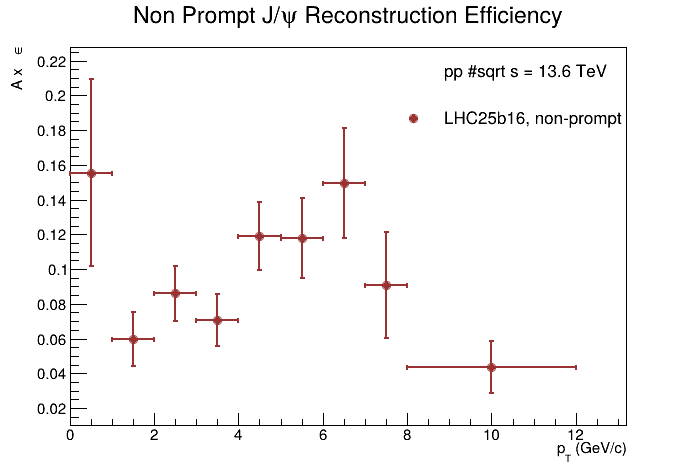

In [95]:
cEta = ROOT.TCanvas()
# graph.SetTitle("Non Prompt J/#psi Reconstruction Efficiency (over 'sel')")
graph25b16promptEta.Draw("AP")
legendPromptEta.Draw()
cEta.Draw()